In [431]:
import pandas as pd
import json
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.visualize import (get_runs_and_cfgs, plot_loss, plot_anomaly, print_cfg, 
        print_cfgs, plot_run, print_runs)
import matplotlib

In [352]:
data_path = '../text-anomaly-detection/data/'

In [353]:
def get_run_df(run):
    with open(f"{run}/val_losses_desc.json", 'r') as fp:
        val_loss = json.load(fp)
    with open(f"{run}/train_losses_desc.json", 'r') as fp:
        train_loss = json.load(fp)
    with open(f"{run}/anomaly.json", 'r') as fp:
        anomaly_score = json.load(fp)

    val_df =  pd.DataFrame(data=val_loss).transpose()#.drop('name', axis=1)
    train_df =  pd.DataFrame(data=train_loss).transpose()#.drop('name', axis=1)
    anomaly_score_df =  pd.DataFrame(data=anomaly_score).transpose()#.drop('name', axis=1)

    try:
        with open(f"{run}/anomaly_scores.pickle", "rb") as fh:
            anomaly = pickle.load(fh)
    except FileNotFoundError:
        anomaly = None

    return train_df, val_df, anomaly, anomaly_score_df

In [468]:
def get_datetime(run):
    return ' '.join(run.split('/')[-3:-1])

def has_files(run):
    return 'anomaly.json' in os.listdir(run)

def last_epoch(run):
    if not has_files(run):
        return None
    with open(f"{run}/anomaly.json", 'r') as fp:
        anomaly_score = json.load(fp)
    return max([int(k) for k in anomaly_score.keys()])

def get_losses(run):
    train_df, val_df, anomaly, anomaly_score_df = get_run_df(run)
    i = np.argmin(train_df['recon_loss'].values)
    j = np.argmin(val_df['recon_loss'].values)
    k = np.argmax(anomaly_score_df['auc_recon'].values)
    l = np.argmax(anomaly_score_df['auc_kl'].values)
    
    return {
        'train_recon': train_df['recon_loss'].iloc[i],
        
        'val_kl': val_df['kl_loss'].iloc[i],
        'val_kl_last': val_df['kl_loss'].iloc[-1],
        'val_kl_best_auc': val_df['kl_loss'].iloc[l],
        
        'val_recon': val_df['recon_loss'].iloc[i],
        'val_recon_best': val_df['recon_loss'].iloc[j],
        'val_recon_best_auc': val_df['recon_loss'].iloc[k],
        'val_recon_last': val_df['recon_loss'].iloc[-1],
        
        'auc_recon_last': anomaly_score_df['auc_recon'].iloc[-1],
        'auc_recon_best': anomaly_score_df['auc_recon'].iloc[k],
        
        'auc_kl_last': anomaly_score_df['auc_kl'].iloc[-1],
        'auc_kl_best': anomaly_score_df['auc_kl'].iloc[l],
    }

def plot_anomaly_run(run):
    train_df, val_df, anomaly, anomaly_score_df = get_run_df(run)
    plt.plot(anomaly_score_df['auc_kl'].values,'k-', label='Anomaly KL',linewidth=2.0)
    plt.plot(anomaly_score_df['auc_recon'].values,'k--', label='Anomaly Recon',linewidth=2.0)
    print(anomaly_score_df['auc_recon'].values[-1])
    i = np.argmax(anomaly_score_df['auc_recon'].values)
    print(i, anomaly_score_df['auc_recon'].values[i])

    plt.legend(loc='upper right')

def plot_vae_run(run, plot_kl=True):
    train_df, val_df, anomaly, anomaly_score_df = get_run_df(run)
    if plot_kl:
        plt.plot(train_df['kl_loss'].values,'r:', label='KL Div. - train',linewidth=2.0)
        plt.plot(val_df['kl_loss'].values,'k:', label='KL Div. - val',linewidth=2.0)
        
    plt.plot(train_df['recon_loss'].values, 'r', label='Recon Loss - train',linewidth=2.0)
    plt.plot(val_df['recon_loss'].values,'k', label='Recon Loss - val',linewidth=2.0)
    
    
    plt.yscale('log')
    plt.legend(loc='upper right')
    i = np.argmin(train_df['recon_loss'].values)
    print(i, train_df['recon_loss'].iloc[i])
    j = np.argmin(val_df['recon_loss'].values)
    print(j, val_df['recon_loss'].iloc[j])
    print(i, val_df['recon_loss'].iloc[i])
    
    

In [417]:
runs, cfgs = get_runs_and_cfgs('../text-anomaly-detection/data/')

In [418]:
df = pd.DataFrame({'runs': runs, 'configs': cfgs})
df.configs.str.replace('\\n', '\n')
df['datetime'] = df.runs.apply(get_datetime)
df['epochs'] = df.runs.apply(last_epoch)
df = df[~df.epochs.isna()]
df['source'] = df.configs.apply(lambda x: x[-4].strip())
df['ood_source'] = df.configs.apply(lambda x: x[-3].strip())
df['tag'] = df.configs.apply(lambda x: x[0].strip())
# model_setup_df = df.configs.apply(lambda x: json.loads(x[-1])).apply(pd.Series)
# kl_setup_df = df.configs.apply(lambda x: json.loads(x[-1])).apply(pd.Series)
# df = pd.concat([df, kl_setup_df, model_setup_df] , axis=1)
df['kl_scale'] = df.configs.apply(lambda x: json.loads(x[-2])['scale'])
losses_df = df.runs.apply(get_losses).apply(pd.Series)
df = pd.concat([df, losses_df] , axis=1)

In [419]:
# df.sort_values('datetime')

In [420]:
# # print to clean
# for r in df[df.epochs.isna()].runs:
#     print(r)

In [421]:
important_runs = ['11-30 19:20', '11-30 19:31', '12-01 14:29', '12-01 09:09',
                  '12-01 18:02', '12-05 12-57',
                  '12-02 09:01', '12-05 15-59', '12-05 17:42','12-05 22:24',
                  '12-05 18:05', '12-05 23:06', '12-06 09:07'
                 ]
pd.options.display.float_format = "{:,.3f}".format
df[df.datetime.isin(important_runs) & (df.source == 'parliament-corpus')].sort_values('datetime')[
    ['datetime', 'tag', 'kl_scale', 'auc_recon_best', 'val_recon', 'val_recon_best_auc', 'val_kl', 'val_kl_best_auc']
]

,datetime,tag,kl_scale,auc_recon_best,val_recon,val_recon_best_auc,val_kl,val_kl_best_auc
7,12-01 09:09,parliament vs friends z=256 emb=50 bs=32,0.050,0.878,0.350,1.691,675.026,675.026
9,12-01 14:29,parliament vs friends scale=0.2 bs=32,0.200,0.917,1.347,3.934,70.889,0.038
8,12-01 18:02,parliament vs friends scale=1 bs=32,1.000,0.916,1.147,3.881,"1,570.026",0.365
13,12-02 09:01,parliament vs friends scale=0.05 bs=32 word_dr...,0.050,0.880,0.331,1.454,648.830,648.830
0,12-05 12-57,LM parliament vs friends bs=32,0.200,0.847,8.434,8.433,0.000,0.000
2,12-05 15-59,AE parliament vs friends scale=0 bs=32,0.000,0.782,0.447,0.712,"2,345.258","2,405.080"
3,12-05 17:42,EVAL |12-01/14:29/1|,0.200,0.846,4.012,4.012,0.135,0.135


## plot learning progress

0 2.3510839847961833
0 1.1470148211970004
0 1.1470148211970004
0.9043054958593016
5 0.9155904355276306


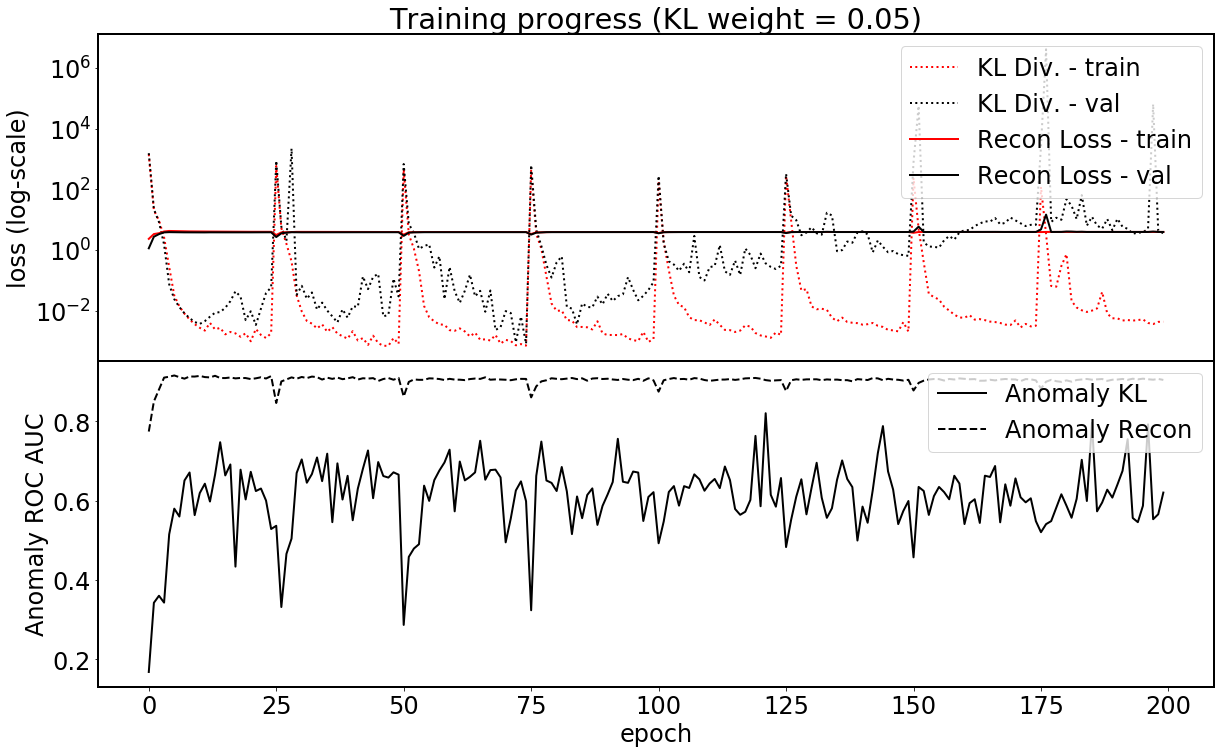

In [483]:
# run_time = '12-01 09:09' 
# run_time = '12-01 14:29'
run_time = '12-01 18:02'
row = df.set_index('datetime').loc[run_time]
matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams['axes.linewidth'] = 2 
plt.figure(figsize=(20,12))
plt.subplot(2,1,1)
plt.xlabel('epoch')
plt.ylabel('loss (log-scale)')
plt.title('Training progress (KL weight = 0.05)')
plot_vae_run(row.runs, plot_kl=True)
# plt.ylim((0, 1000))
plt.subplot(2,1,2)
plot_anomaly_run(row.runs)
plt.xlabel('epoch')
plt.ylabel('Anomaly ROC AUC')

plt.subplots_adjust(hspace=.0)


# Likelihood ratio

In [378]:
def scores_for_run(run_time, epoch=None):
    anomaly, labels, ll = get_anomaly_and_labels(df.set_index('datetime').loc[run_time], epoch=epoch) # par vs sup
    print('AUC:', roc_auc_score(labels, anomaly))
    print('AUC (+LR):', roc_auc_score(labels, anomaly + ll))

In [379]:
def get_ll(row):
    s1 = row.source
    s2 = row.ood_source
    with open(f'{data_path}/general_likelihoods_{s1}.pickle', 'rb') as fh:
        ll1 = pickle.load(fh)

    with open(f'{data_path}/general_likelihoods_{s2}.pickle', 'rb') as fh:
        ll2 = pickle.load(fh)
    
    ll = np.concatenate([ll1, ll2])
    return ll1, ll2, ll

def get_anomaly(row, epoch=None):
    train_df, val_df, anomaly, anomaly_score_df = get_run_df(row.runs)
    if epoch is None:
        epoch = max(anomaly.keys())
    return anomaly[epoch]['recon']

def get_anomaly_and_labels(row, epoch=None):
    print(row.source, row.ood_source)
    anomaly = get_anomaly(row, epoch=epoch)
    ll1, ll2, ll = get_ll(row)
    labels = np.concatenate([np.zeros(ll1.shape), np.ones(ll2.shape)])
    return anomaly, labels, ll

In [380]:
print('LM')
scores_for_run('12-05 12-57', epoch=7)
print('AE')
scores_for_run('12-05 15-59', epoch=10)

LM
parliament-corpus friends-corpus
AUC: 0.8254608600057268
AUC (+LR): 0.7460219042494262
AE
parliament-corpus friends-corpus
AUC: 0.7689294454518512
AUC (+LR): 0.8334174125465252


In [384]:
scores_for_run('12-01 14:29') # par vs friends
scores_for_run('12-05 17:42') # par vs sup
scores_for_run('12-05 18:05') # friends vs par
scores_for_run('12-05 23:06') # friends vs sup
# scores_for_run('12-05 22:24', epoch=23) # sup vs friends #TODO: remove epoch
scores_for_run('12-05 22:24') # sup vs friends
scores_for_run('12-06 09:07') # friends vs sub

parliament-corpus friends-corpus
AUC: 0.9088681148045631
AUC (+LR): 0.9514224068061443
parliament-corpus supreme-corpus
AUC: 0.8460251630797838
AUC (+LR): 0.9194361196238579
friends-corpus parliament-corpus
AUC: 0.9308216059236722
AUC (+LR): 0.959149253948788
friends-corpus supreme-corpus
AUC: 0.7932879506737466
AUC (+LR): 0.8553121944580986
supreme-corpus friends-corpus
AUC: 0.7803496472202138
AUC (+LR): 0.7959878050877585
supreme-corpus parliament-corpus
AUC: 0.8846251695337474
AUC (+LR): 0.9034382295815961


In [437]:

def get_sentences(run_time):
    row = df.set_index('datetime').loc[run_time]
    with open(f"{row.runs}/generated_sentences.json", 'r') as fp:
        sentences = json.load(fp)
    return sentences

In [480]:
sentences = get_sentences('12-01 14:29')
# sentences = get_sentences('12-01 09:09')
# sentences = get_sentences('12-05 18:05')
print('\n'.join(sentences['50']['prior']))
print('')
print('\n'.join(sentences['69']['prior']))
print('')
print('\n'.join(sentences['99']['prior']))

<start> however we have already been offered a temporary ps 1 billion of helping <eos> <eos>
<start> whatever this is he hides much inefficient on which this <eos> <eos> <eos> <eos> <eos>
<start> notwithstanding that allegation had been raised by a lord chancellor <eos> <eos> <eos> <eos> <eos>
<start> education is fully with wirral seats but perhaps people are not the <eos> <eos> <eos>
<start> yes of course not get a misapprehension for all <eos> <eos> <eos> <eos> <eos> <eos>

<start> is that a good news for the approach that he started <eos> for <eos> the
<start> i have read my hon friend that the figures into wirral and industry <eos> <eos>
<start> i can give serious examples as a one i in my constituency <eos> <eos> <eos>
<start> my hon friend will realise that that will cause every compatibility of welsh <eos> <eos>
<start> the hon gentleman that there is widespread over the next year 's look for <eos>

<start> i do not consider whether the targets <eos> require british civil peopl

In [470]:
sentences['99']['val']

[{'target': '<start> i hope that this will be a case of third time lucky <eos> <pad>',
  'reconstruction': 'i hope that this will be a case of getting parts <eos> <eos> <eos> <eos>',
  'z_sample': '<start> i repeat that we will be the case of getting right <eos> <eos> <eos> <eos>'},
 {'target': '<start> unsurprisingly i disagree with the perspective at the end of the hon lady <eos>',
  'reconstruction': 'korea anyone wait with the facts of the end of the hon lady <eos> <eos>',
  'z_sample': '<start> factually anyone else after the killers at the end of the hon lady <eos> <eos>'},
 {'target': '<start> outside london however the picture is now very different <eos> <pad> <pad> <pad> <pad>',
  'reconstruction': 'as that however the picture is often very different <eos> <eos> <eos> <eos> <eos> <eos>',
  'z_sample': '<start> does that answer the availability of england is different <eos> <eos> <eos> <eos> <eos> <eos>'},
 {'target': '<start> why does the right hon gentleman not look after bri

In [476]:
print('\n'.join(get_sentences('12-05 17:42')['0']['prior']))

get_sentences('12-05 23:06')['0']['prior']

<start> what he does it both is useful <eos> <eos> <eos> owned and <eos> <eos> <eos>
<start> my hon friend says that he is wide ranging question <eos> <eos> <eos> <eos> <eos>
<start> electronic cash and 1996 labour japanese interested are coming from it <eos> <eos> <eos> <eos>
<start> which will way of which to give the house <eos> for a future <eos> <eos>
<start> i have every word room me to which it was not strong experience <eos> <eos>
<start> i refer to ensure that it will not happen ahead <eos> <eos> <eos> <eos> <eos>
<start> will the minister consider the local authority divides and industry will share the <eos> problem
<start> this question is being a strange department and could be done <eos> <eos> <eos> <eos>
<start> labour 's answer tells us to all about the community election on security <eos> <eos>
<start> is it conducted a bit of childcare under that winter closures in private sector <eos>


['<start> hey jake never know everything <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>',
 '<start> i am not order it there <eos> <eos> <eos> <eos> <eos> <eos> here <eos> <eos>',
 "<start> you 're just being <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> right <eos> <eos>",
 '<start> sure women for coming friends with the night who does this <eos> <eos> <eos> <eos>',
 "<start> y'know who if everybody needs to be a caterer do n't <eos> <eos> <eos> y'know",
 '<start> which is what a loser say for me <eos> <eos> <eos> <eos> <eos> <eos> <eos>',
 "<start> ok yeah after i got ta kiss the pants and he 's really <eos> <eos>",
 "<start> oh you believe billy joel y'know <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>",
 '<start> i meant ta start reading <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>',
 "<start> what 's the identical hand twin <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>"]

friends:

i 'm not even considering not jealous anymore

oh you believe billy joel y'know

which is what a loser say for me

parliament

notwithstanding that allegation had been raised by a lord chancellor 

is that a good news for the approach that he started

my hon friend will realise that that will cause every compatibility of welsh